In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [4]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [5]:
df.shape

(35494, 14)

In [6]:
df.head()

,userId,itemId,rating,mean_on_self,min_on_self,max_on_self,mean_on_other,min_on_other,max_on_other,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid
3297,159,241,0.5,1.0,1.0,1.0,NaN,NaN,NaN,train,1,1,1,0
16463,673,7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,train,2,2,1,0
35390,1502,255,3.5,NaN,NaN,NaN,NaN,NaN,NaN,train,3,3,1,0
5367,224,10,4.0,1.0,1.0,1.0,NaN,NaN,NaN,train,4,4,1,0
13666,557,9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,train,5,5,1,0


In [7]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [8]:
df_train.head()

,userId,itemId,rating,mean_on_self,min_on_self,max_on_self,mean_on_other,min_on_other,max_on_other,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid
3297,159,241,0.5,1.0,1.0,1.0,NaN,NaN,NaN,train,1,1,1,0
16463,673,7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,train,2,2,1,0
35390,1502,255,3.5,NaN,NaN,NaN,NaN,NaN,NaN,train,3,3,1,0
5367,224,10,4.0,1.0,1.0,1.0,NaN,NaN,NaN,train,4,4,1,0
13666,557,9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,train,5,5,1,0


### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(df_train[['user_idx','item_idx']],df_train['rating'])
dsvalid=cfdata(df_valid[['user_idx','item_idx']],df_valid['rating'])

In [11]:
df_train.shape

(31944, 14)

In [12]:
bs=64

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,True)

In [15]:
len(user_to_idx),len(movie_to_idx)

(1508, 2071)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=25
n_emb_movie=25
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[75,15]
dropouts=[0.2,0.2]

In [17]:
n_users

1508

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

1508

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)

In [21]:
cfobj

cf(
  (emb_user): Embedding(1509, 25)
  (emb_item): Embedding(2072, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[1.0206],
         [1.2422],
         [3.4312],
         [2.9187],
         [0.6964],
         [3.5592],
         [2.8754],
         [0.6329],
         [2.4794],
         [2.3193],
         [2.9902],
         [2.4628],
         [0.6011],
         [2.2706],
         [0.9432],
         [0.5860],
         [3.0701],
         [2.4120],
         [0.6268],
         [3.4571],
         [1.7082],
         [3.8264],
         [1.2330],
         [1.3298],
         [0.6407],
         [1.9504],
         [0.9400],
         [3.8865],
         [3.8292],
         [2.9746],
         [1.7232],
         [0.6103],
         [1.2938],
         [1.9928],
         [0.5214],
         [2.8488],
         [1.4991],
         [1.2161],
         [3.6504],
         [3.8596],
         [0.5626],
         [3.2024],
         [3.4368],
         [1.2379],
         [3.1977],
         [3.9316],
         [2.3130],
         [2.4708],
         [2.6604],
         [3.8870],
         [3.9273],
         [0.8489],
         [3.

## Learner

In [25]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [26]:
if 1==0:
    del cfobj
    torch.cuda.empty_cache()

In [27]:
device='cuda:0'

In [49]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)

In [50]:
cfobj=cfobj.to(device)

In [51]:
cfobj

cf(
  (emb_user): Embedding(1509, 25)
  (emb_item): Embedding(2072, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [52]:
len(dltrain)

500

In [53]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [54]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

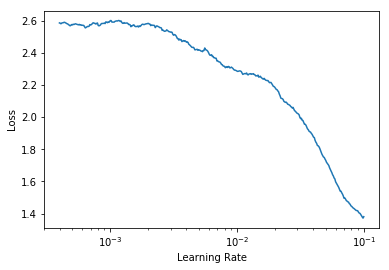

In [55]:
learner.plot_lrs(100)

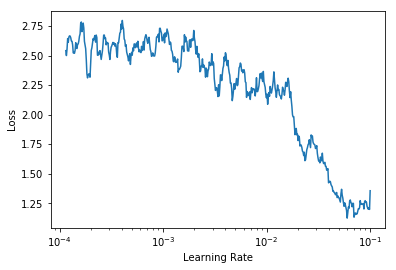

In [56]:
learner.plot_lrs(10)

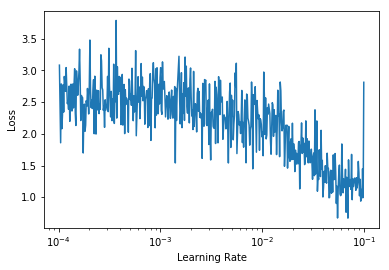

In [57]:
learner.plot_lrs(1)

In [68]:
del cfobj
torch.cuda.empty_cache()

In [69]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [70]:
device

'cuda:0'

In [71]:
wd=5e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0)

In [72]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.03 Weight Decay 0.0005 Train Loss:1.0003579560518265                 Valid Loss:0.7190363832882473 Train RMSE:0.9753862561789296 Valid RMSE:0.8447840316725274
Epoch:1 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7258845695853233                 Valid Loss:0.7038018458655902 Train RMSE:0.8478785905593832 Valid RMSE:0.8347365840069116
Epoch:2 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7200535539388656                 Valid Loss:0.715238131582737 Train RMSE:0.8443708716006748 Valid RMSE:0.8425993283700418


In [73]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7229606779813766                 Valid Loss:0.7003944292664528 Train RMSE:0.8461036961776377 Valid RMSE:0.8322243446607024
Epoch:1 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7243420504331589                 Valid Loss:0.7193742319941521 Train RMSE:0.847193811574359 Valid RMSE:0.84438990225557
Epoch:2 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7160705160498619                 Valid Loss:0.7092556884246213 Train RMSE:0.8421267305444495 Valid RMSE:0.8380155879642065


In [74]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7191795055866241                 Valid Loss:0.711165998663221 Train RMSE:0.8442067040373957 Valid RMSE:0.8404164722506587
Epoch:1 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7212334573864937                 Valid Loss:0.6984302039657321 Train RMSE:0.8453526573405209 Valid RMSE:0.832358665683828
Epoch:2 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7181714141964912                 Valid Loss:0.7070252852780479 Train RMSE:0.843919280657125 Valid RMSE:0.8383819092898817


In [75]:
for param_group in optimizer.param_groups:
    param_group['lr']=3e-2

In [76]:
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=3,start_lr=3e-2, end_lr=1e-3)

In [77]:
learner.run_epochs(dltrain,dlvalid,11)

Epoch:0 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.7205146877765656                 Valid Loss:0.7041519965444293 Train RMSE:0.8450783620938787 Valid RMSE:0.8367375537084188
Epoch:1 Learning rate 0.0096548938460563 Weight Decay 0.0005 Train Loss:0.6550165495276451                 Valid Loss:0.6625344114644187 Train RMSE:0.8056173757610974 Valid RMSE:0.8113117686642254
Epoch:2 Learning rate 0.0031072325059538597 Weight Decay 0.0005 Train Loss:0.59630205732584                 Valid Loss:0.653099927519049 Train RMSE:0.7692461065086449 Valid RMSE:0.804291236828324
Epoch:3 Learning rate 0.0010000000000000005 Weight Decay 0.0005 Train Loss:0.5612417240738868                 Valid Loss:0.6531774806124824 Train RMSE:0.7458618665361549 Valid RMSE:0.8048764956204941
Epoch:4 Learning rate 0.03 Weight Decay 0.0005 Train Loss:0.737238563656807                 Valid Loss:0.724527366991554 Train RMSE:0.854485032325103 Valid RMSE:0.8468903278652753
Epoch:5 Learning rate 0.020558748363608464 W

In [78]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [79]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [80]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [81]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((1509, 25), (2072, 25), (1509, 1), (2072, 1))

In [82]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))